In [1]:
from dolfinx import default_scalar_type
from dolfinx import fem
from dolfinx.fem import (Constant, Expression, Function, functionspace, locate_dofs_topological,
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical, assemble_matrix)
from dolfinx.fem.petsc import LinearProblem
from dolfinx import mesh
from dolfinx.plot import vtk_mesh

from mpi4py import MPI

from petsc4py import PETSc

from ufl import (SpatialCoordinate, TestFunction, TrialFunction, inner, dot, ds, dx, grad, Mesh,
                 triangle, nabla_div, Identity, sym, tr, sqrt, Measure)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gmsh, meshio, pygmsh, pyvista, time, ufl

In [2]:
def compute_von_mises_stress(sigma):
    s11 = sigma[0, 0]
    s22 = sigma[1, 1]
    s12 = sigma[0, 1]

    # Von Mises stress formula for plane strain
    von_mises = sqrt(s11**2 + s22**2 - s11 * s22 + 3 * s12**2)
    return von_mises

In [3]:
def generate_quarter_circle_mesh(R: float, h_vtcs: float, q: int, z: float=0):
    with pygmsh.geo.Geometry() as geom:
        points = [
            geom.add_point([0.0, 0.0, z], mesh_size=h_vtcs**q),
            geom.add_point([0.0,  -R, z], mesh_size=h_vtcs**q),
            geom.add_point([  R, 0.0, z], mesh_size=h_vtcs)
        ]

        lines = [
            geom.add_line(points[0], points[1]),  # Vertical line
            geom.add_circle_arc(points[1], points[0], points[2]),  # Circle Arc
            geom.add_line(points[2], points[0]),  # Horizontal line
        ]
        
        # Create a line loop to define the L-shaped domain boundary
        line_loop = geom.add_curve_loop(lines)
        
        surface = geom.add_plane_surface(line_loop)

        mesh = geom.generate_mesh()

    return mesh

In [4]:
# Parameters
R = 1.0  # Radius of quarter circle
F = 5.0  # Magnitude and orientation of concetrated force 

h = 0.025 # mesh size
q = 2 # mesh size power at origin
element_order = 2;

E = 1000
nu = 0.3

lambda_lame = E*nu/(1-2*nu)/(1+nu)
mu_lame = E/2/(1+nu)

kappa = 3 - 4*nu # plane strain

In [5]:
mesh_io = generate_quarter_circle_mesh(R, h, q)

points = mesh_io.points[:, :2]  # Only take the 2D coordinates
triangle_cells = [cell for cell in mesh_io.cells if cell.type == "triangle"]
cells = np.vstack([cell.data for cell in triangle_cells])

ufl_domain = Mesh(triangle)
domain = mesh.create_mesh(MPI.COMM_WORLD, cells.astype(np.int32), points, ufl_domain)

d_dim = domain.geometry.dim
b_dim = d_dim - 1

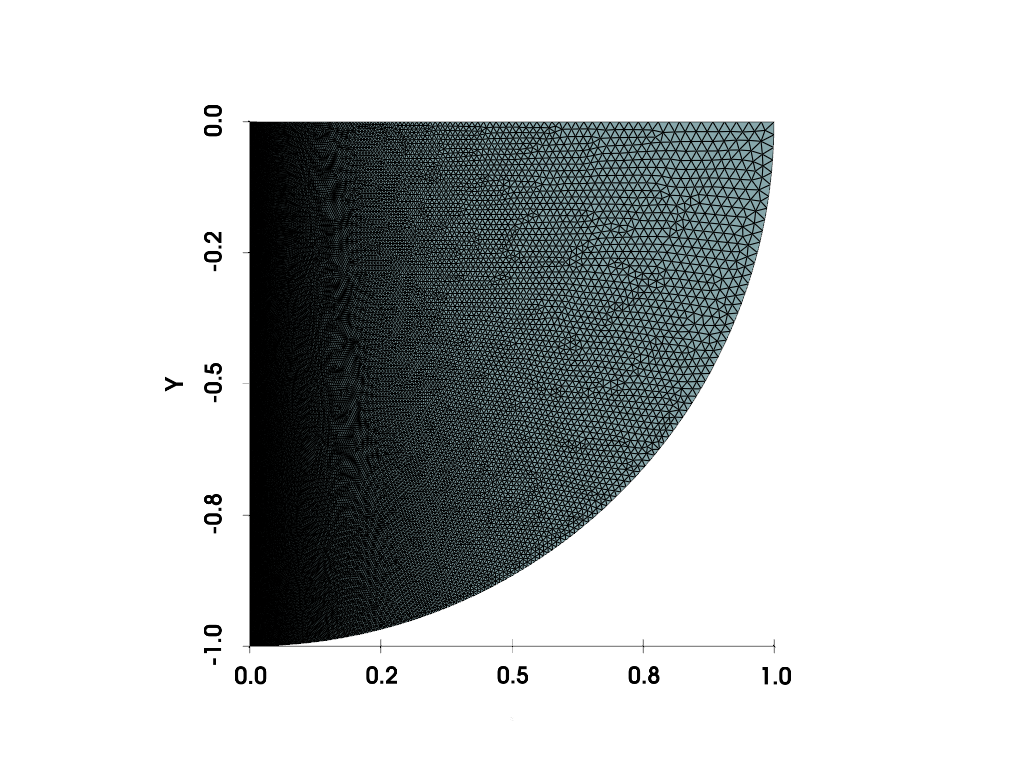

In [6]:
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(domain, 2)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid(
    xtitle='X',        # Custom label for X axis
    ytitle='Y',        # Custom label for Y axis
    grid=None               # Suppress grid lines
)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()

In [7]:
V = functionspace(domain, ("Lagrange", element_order, (d_dim, )))

In [8]:
def fixed_point(x: np.ndarray, x0: np.ndarray):
    tol = 1e-5
    return np.logical_and(
        np.isclose(x[0], x0[0], atol=tol),
        np.isclose(x[1], x0[1], atol=tol)
    )

boundaries = [(0, lambda x: np.isclose(x[0], 0)),
              (1, lambda x: np.isclose(x[0]**2+x[1]**2, R)),
              (2, lambda x: np.isclose(x[1], 0))]

In [9]:
facet_bcs, facet_indices, facet_markers = [], [], []
for (marker, locator) in boundaries:
    facets = mesh.locate_entities_boundary(domain, b_dim, locator)
    facet_bcs.append(facets)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)

facet_tag = mesh.meshtags(domain, b_dim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [10]:
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

In [11]:
left_facets = facet_bcs[0]
left_dofs_x = locate_dofs_topological(V.sub(0), b_dim, left_facets)
left_bc = dirichletbc(default_scalar_type(0), left_dofs_x, V.sub(0))

fixed_dofs = fem.locate_dofs_geometrical(V, lambda x: fixed_point(x, np.array([0, -R])))
fixed_bc = dirichletbc(default_scalar_type((0.0, 0.0)), fixed_dofs, V)

bcs = [left_bc, fixed_bc]

In [12]:
def epsilon(u):
    return sym(grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)

def sigma(u):
    return lambda_lame * nabla_div(u) * Identity(len(u)) + 2 * mu_lame * epsilon(u)

p = ufl.SpatialCoordinate(domain)
r_squared = p[0]**2 + p[1]**2

factor = (2 * F) / (R * ufl.pi * r_squared)
traction = -factor * ufl.as_vector([p[0] * p[1], p[1]**2])

u = TrialFunction(V)
v = TestFunction(V)

a = inner(sigma(u), epsilon(v)) * dx
L = dot(traction,v) * ds(1)

In [13]:
start_time = time.time()

# Assemble system
A = fem.petsc.assemble_matrix(form(a), bcs=bcs)
A.assemble()

b = fem.petsc.assemble_vector(form(L))
fem.apply_lifting(b, [form(a)], bcs=[bcs])
b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
fem.set_bc(b, bcs)

# force vector at the origin
F0 = [0.0, -F]

origin_dofs = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0.0) & np.isclose(x[1], 0.0))
with b.localForm() as b_local:
    for dof in origin_dofs:
        b_local[2*dof] += F0[0]
        b_local[2*dof + 1] += F0[1]

solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType("preonly")
solver.getPC().setType("cholesky")
solver.setFromOptions()

# Solve the system
uh = Function(V)
uh.vector.set(0)
solver.solve(b, uh.vector)
uh.x.scatter_forward()

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time taken to solve the problem: {elapsed_time:.4f} seconds")

Time taken to solve the problem: 75.8622 seconds


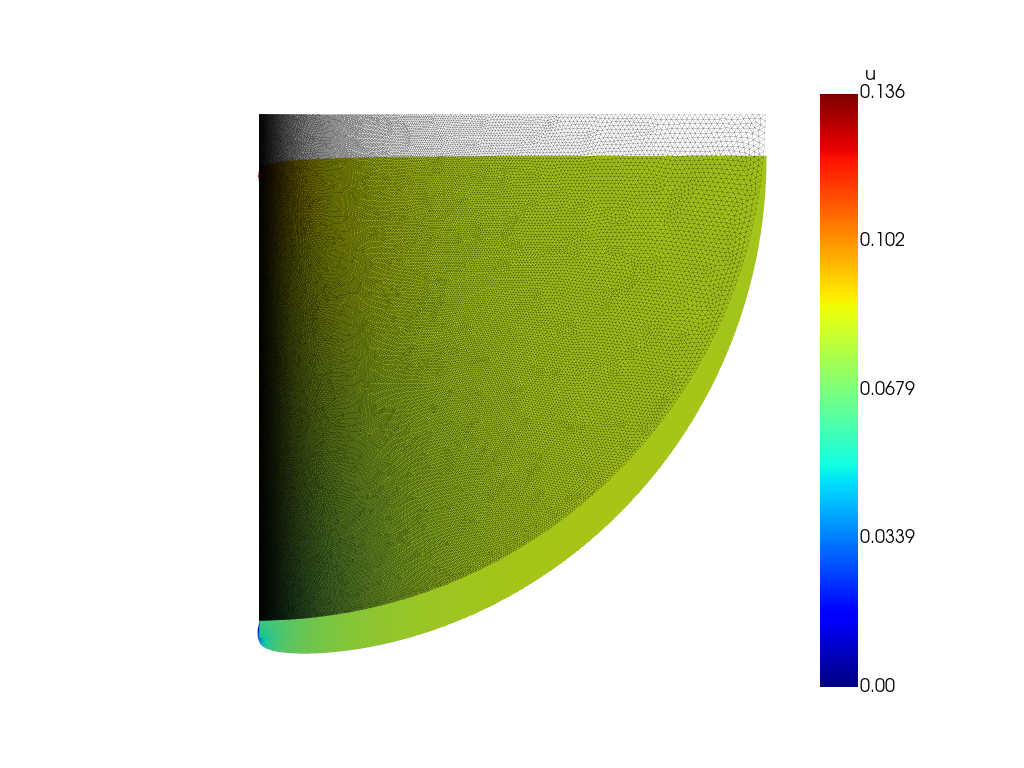

In [14]:
p = pyvista.Plotter()
topology, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Convert the 2D displacements to 3D by adding a zero component for the z-axis
u_3d = np.hstack([uh.x.array.reshape((geometry.shape[0], 2)), np.zeros((geometry.shape[0], 1))])

grid["u"] = u_3d
warped = grid.warp_by_vector("u", factor=1)

scalar_bar_args = {"title": "u", "vertical": True, "position_x": 0.8, "position_y": 0.1, "width": 0.1, "height": 0.8}
actor_0 = p.add_mesh(warped, show_edges=False, cmap="jet", scalar_bar_args=scalar_bar_args)
actor_1 = p.add_mesh(grid, style="wireframe", color="k", opacity=0.1)

p.view_xy()

if not pyvista.OFF_SCREEN:
    p.show()

In [15]:
von_Mises = compute_von_mises_stress(sigma(uh))

V_von_mises = functionspace(domain, ("CG", element_order - 1)) if element_order > 1 else functionspace(domain, ("CG", element_order))
stress_expr = Expression(von_Mises, V_von_mises.element.interpolation_points())
stresses = Function(V_von_mises)
stresses.interpolate(stress_expr)

vm_vertex_values = stresses.x.array
vm_max = np.max(vm_vertex_values)
print(f'Maximum von Mises stress: {vm_max:.2e}')

Maximum von Mises stress: 6.48e+04


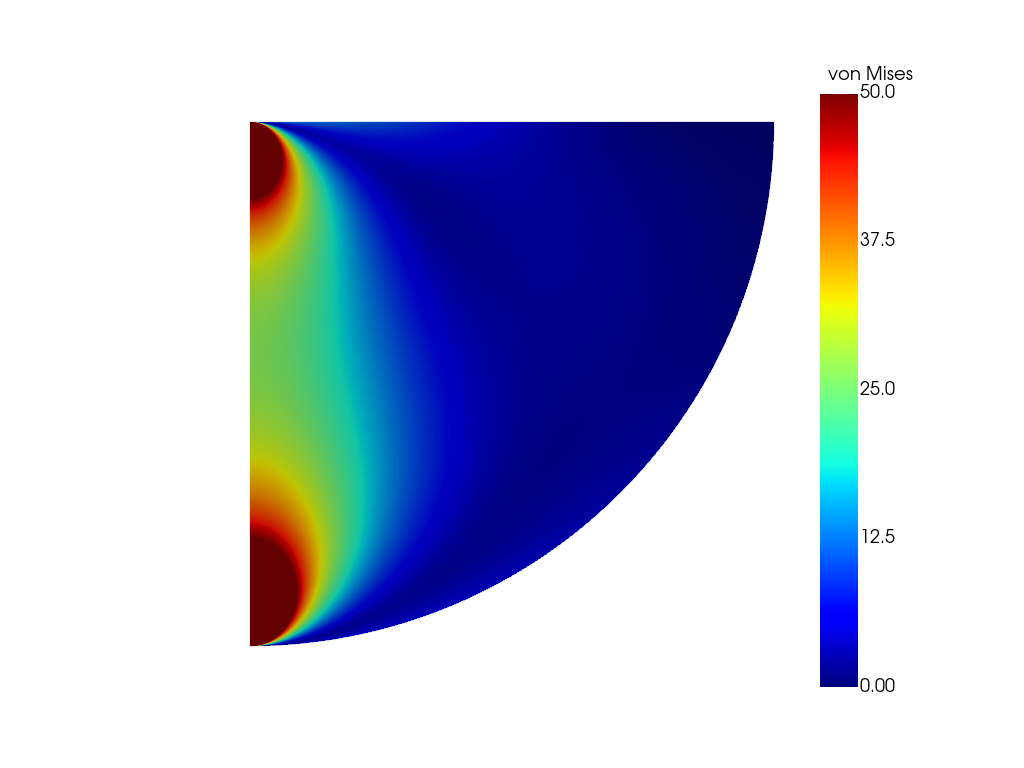

In [16]:
s_topology, s_cell_types, s_geometry = vtk_mesh(V_von_mises)
s_grid = pyvista.UnstructuredGrid(s_topology, s_cell_types, s_geometry)
s_grid.point_data["s"] = stresses.x.array.real
s_grid.set_active_scalars("s")
s_plotter = pyvista.Plotter()

scalar_bar_args = {"title": "von Mises", "vertical": True, "position_x": 0.8, "position_y": 0.1, "width": 0.1, "height": 0.8}
s_plotter.add_mesh(s_grid, show_edges=False, clim=[0,50], cmap="jet", scalar_bar_args=scalar_bar_args)
s_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    s_plotter.show()

In [30]:
energy_density = 0.5*inner(sigma(uh), epsilon(uh))
energy_form = energy_density * dx

energy_form = fem.form(energy_form)
energy = fem.assemble_scalar(energy_form)
energy = domain.comm.allreduce(energy, op=MPI.SUM)

print("Strain energy: ", energy)

u_vertex_values = uh.x.array
u0 = u_vertex_values[2*origin_dofs[0] + 1]
print("uh(0,0) = ", u0)

Strain energy:  0.4392206098464408
uh(0,0) =  -0.13579291103868552
